Haina Yu Final Project Submission

Milestone I

1.(a) Implement a function to ro produce urls for all the SDO synoptic frames (see below in Data details) for a particular wavelength that you plan to access. In the beginning, use large cadence (say one image every few days), so you don't need to download many images. 

In [12]:
import time

def get_aia_image_urls(year=2023, filt='0211', day_cadence=2):
    base_url = f'http://jsoc.stanford.edu/data/aia/synoptic/{year}/'
    day_cadence = max(day_cadence, 2)

    for month in range(1, 13): 
        for day in range(1, 32, day_cadence):
            formatted_month = str(month).zfill(2)
            formatted_day = str(day).zfill(2)
            try:
                if int(formatted_day) == '29' and int(formatted_month) == '02':
                    continue
                elif int(formatted_day) > 30 and formatted_month in ['04', '06', '09', '11']:
                    continue
                else:
                    time.strptime('{}-{}-{}'.format(year, formatted_month, formatted_day), '%Y-%m-%d')
            
            except ValueError:
                continue
           
            url = f"{base_url}{formatted_month}/{formatted_day}/H0000/AIA{year}{formatted_month}{formatted_day}_0000_{filt}.fits"
            yield url

1.(b)Implement a class AImage that can be initialized with a FITS file of an image and initialization parameters, cropping the area for analysis to a specific multiple of Sun's radius (see example code below), and implements methods that can compute several basic statistics on the image, such as median and different percentiles using np.median() and np.percentile().

In [7]:
import numpy as np
from astropy.io import fits
import re

class AImage:
    def __init__(self, url, rsun_factor=1, minval=0.01):
        self.url = url
        self.image, self.img_header = self.read_aia_synoptic_image(url)
        self.image, self.limit_array = self.set_sun_aperture(self.image, self.img_header, rsun_factor)


    def read_aia_synoptic_image(self, url): 
        with fits.open(url) as fimg:
            image = fimg[1].data
            img_header = fimg[1].header
        return image, img_header

    def set_sun_aperture(self, img, img_header, rsun_factor):
        r_sun = img_header["IMSCL_MP"] * img_header['R_SUN']
        dx_pix2sec, dy_pix2sec = img_header['CDELT1'], img_header['CDELT2']
        _img = np.copy(img)
        nrow, ncol = np.shape(_img)
        nrh = nrow // 2
        nch = ncol // 2
        Y, X = np.ogrid[:nrow, :ncol]
        rcenter = np.sqrt(((X - nch)*dx_pix2sec)**2 + ((Y - nrh)*dy_pix2sec)**2)
        rcut = rsun_factor * r_sun
        limit = rcenter < rcut
        _img[~limit] = 0 
        return _img[limit], limit

    def compute_median(self):
        return np.median(self.image)

    def compute_percentile(self, percentile):
        return np.percentile(self.image, percentile)
    
    def compute_mean(self):
        return np.mean(self.image)


1.(c) Demonstrate that your class works, by using it to process a specific image and plotting input image and outputing mean, median, and several percentiles.

In [8]:
url = 'http://jsoc.stanford.edu/data/aia/synoptic/2023/01/01/H0000/AIA20230101_0000_0211.fits'
aimage = AImage(url, rsun_factor=0.5)
print(f"Mean: {aimage.compute_mean()}")
print(f"Median: {aimage.compute_median()}")
print(f"16th Percentile: {aimage.compute_percentile(16)}")
print(f"84th Percentile: {aimage.compute_percentile(84)}")

Mean: 104.76826991909971
Median: 58.8125
16th Percentile: 36.625
84th Percentile: 136.6875


1.(d)Design a blueprint (skeleton structure with minimum of functions needed without actual content) for a class TimeSeries (or a more descriptive and better sounding name of your choice) that can be initialized with parameters specifying date range for analysis and cadence, process images within this date range and with specified time cadence from the AIA Synoptic data base and analyze them using AImage.

In [9]:
class TimeSeries:
    def __init__(self, start, end, cadence, wavelength, rsun=1, minval=0.01):
        self.start = start
        self.end = end
        self.cadence = cadence
        self.wavelength = wavelength
        self.rsun = rsun
        self.minval = minval
        self.images = []
        self.stats = []

    def process_images(self):
        urls_generator = get_aia_image_urls(self.start, self.end, self.wavelength, self.cadence)
        for url in urls_generator:
            try:
                if url: 
                    img = AImage(url, self.rsun, self.minval)
                    self.images.append(img)
                    date = img.extract_date(url) 
                if date is not None:
                    self.dates.append(date)
            except Exception as e:
                print(f"Error processing image from URL {url}: {e}")
                continue

    def analyze_stats(self):
        for img in self.images:
            median = img.compute_median()
            percentile = img.compute_percentile(100)
            mean = img.compute_mean()
            highest = img.image.max()
            lowest = img.image.min()
            self.stats.append((median, percentile, mean,highest,lowest))

    def print_date_range(start, end, cadence):
        return f"Selected date range: {start} to {end}\nParameters specifying date range for analysis: start={start}, end={end}\nCadence: {cadence}"


    def plot_time_series(self):
        df = pd.DataFrame(self.stats, columns=['Median', 'Percentile', 'Mean', 'Max', 'Min'])
        df['Date'] = pd.to_datetime(self.dates)  
        plt.figure(figsize=(10, 6))
        plt.plot(df['Date'], df['Median'], label='Median')
        plt.fill_between(df['Date'], df['16th Percentile'], df['84th Percentile'], color='gray', alpha=0.5)
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend()
        plt.show()

Milestone II

2.(a)Finish implementation of class TimeSeries that can be initialized with parameters specifying date range for analysis and cadence, load images within this date range and with specified time cadence from the AIA Synoptic data base and analyze them using AImage. Statistics resulting from this analysis for a given date range and cadence should be recorded and saved into csv format using pandas, as illustrated below.

In [13]:
import pandas as pd
from datetime import datetime, timedelta

def get_aia_image_urls(start_date, end_date, filt='0211', day_cadence=2):
    '''
    Read FITS files with SDO images of the Sun for a given date and filter
    '''
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    day_cadence = max(day_cadence, 2)

    while start_date <= end_date:
        year = start_date.year
        formatted_month = str(start_date.month).zfill(2)
        formatted_day = str(start_date.day).zfill(2)
        base_url = f'http://jsoc.stanford.edu/data/aia/synoptic/{year}/'
        url = f"{base_url}{formatted_month}/{formatted_day}/H0000/AIA{year}{formatted_month}{formatted_day}_0000_{filt}.fits"
        yield url
        start_date += timedelta(days=day_cadence)




In [14]:
import numpy as np
from astropy.io import fits

class AImage:
    def __init__(self, url, rsun_factor=1, minval=0.01):
        self.image, self.img_header = self.read_aia_synoptic_image(url)
        self.image = self.set_sun_aperture(self.image, self.img_header, rsun_factor)

    def read_aia_synoptic_image(self, url): 

        with fits.open(url) as fimg:
            image = fimg[1].data
            img_header = fimg[1].header
        return image, img_header

    def set_sun_aperture(self, img, img_header, rsun_factor, minval):

      r_sun = img_header["IMSCL_MP"] * img_header['R_SUN']
      dx_pix2sec, dy_pix2sec = img_header['CDELT1'], img_header['CDELT2']
      _img = np.copy(img)
      nrow, ncol = np.shape(_img)
      nrh = nrow // 2
      nch = ncol // 2
      Y, X = np.ogrid[:nrow, :ncol]
      rcenter = np.sqrt(((X - nch)*dx_pix2sec)**2 + ((Y - nrh)*dy_pix2sec)**2)
      rcut = rsun_factor * r_sun
      _img[rcenter < rcut] = np.clip(_img[rcenter < rcut], None, maxval)     
      return _img

    def compute_median(self):
        return np.median(self.image)

    def compute_percentile(self, percentile):
        return np.percentile(self.image, percentile)
    
    def compute_mean(self):
        return np.mean(self.image)

In [15]:
import pandas as pd

class TimeSeries:
    def __init__(self, start, end, day_cadence=2, wavelength='0021', rsun=1, minval=0.01):
        self.start = start
        self.end = end
        self.cadence = day_cadence
        self.wavelength = wavelength
        self.rsun = rsun
        self.minval = minval
        self.images = []
        self.stats = []
    
    def process_images(self):
        urls = list(get_aia_image_urls(self.start, self.end, self.wavelength, self.cadence))
        for url in urls:
            img = AImage(url, self.rsun, self.minval)  
            self.images.append(img)
    
    def analyze_stats(self):
        for img in self.images:
            median = img.compute_median()
            percentile = img.compute_percentile(16)
            percentile = img.compute_percentile(84)
            mean = img.compute_mean()
            self.stats.append((median, percentile, mean))
    
    
    def save_to_csv(self, filename):
        df = pd.DataFrame(self.stats, columns=['Median', 'Percentile', 'Mean'])
        df.to_csv(filename, index=False)


ts_Xrays = TimeSeries('2023-01-01', '2023-01-31', 2, '0094', 1.5, 0.01)
print("The data for 0094 is stored in", ts_Xrays)
ts_UV = TimeSeries('2023-01-01', '2023-01-31', 2, '0211', 1.5, 0.01)
print("The data for 0211 is stored in", ts_UV)

The data for 0094 is stored in <__main__.TimeSeries object at 0x7fe30bef4a90>
The data for 0211 is stored in <__main__.TimeSeries object at 0x7fe5709d1e50>


2.(b) Analyze AIA synoptic images with a cadence of at least one day or better in two filters: X-rays (0094) to UV (1600). Use the TimeSeries objects to construct activity time series with the median and 16 and 84 percentiles to store time series for each filter in a file in the csv format. Plot the median as a function of time for the series you created and the region between 16th and 84th percentiles as a shaded area.

In [16]:
import numpy as np
from astropy.io import fits
import re

class AImage:
    def __init__(self, url, rsun_factor=1, minval=0.01):
        self.url = url
        self.date = self.extract_date(url) 
        self.image, self.img_header = self.read_aia_synoptic_image(url)
        self.image, self.limit_array = self.set_sun_aperture(self.image, self.img_header, rsun_factor)

    def extract_date(self, url):
        date_pattern = r'\d{4}/\d{2}/\d{2}'
        match = re.search(date_pattern, url)
        if match:
            date = match.group(0)
            return date
        else:
            print("No date found in the URL given.")
            return None

    def read_aia_synoptic_image(self, url): 
        with fits.open(url) as fimg:
            image = fimg[1].data
            img_header = fimg[1].header
        return image, img_header

    def set_sun_aperture(self, img, img_header, rsun_factor):
        r_sun = img_header["IMSCL_MP"] * img_header['R_SUN']
        dx_pix2sec, dy_pix2sec = img_header['CDELT1'], img_header['CDELT2']
        _img = np.copy(img)
        nrow, ncol = np.shape(_img)
        nrh = nrow // 2
        nch = ncol // 2
        Y, X = np.ogrid[:nrow, :ncol]
        rcenter = np.sqrt(((X - nch)*dx_pix2sec)**2 + ((Y - nrh)*dy_pix2sec)**2)
        rcut = rsun_factor * r_sun
        limit = rcenter < rcut
        _img[~limit] = 0 
        return _img[limit], limit

    def compute_median(self):
        return np.median(self.image)

    def compute_percentile(self, percentile):
        return np.percentile(self.image, percentile)
    
    def compute_mean(self):
        return np.mean(self.image)

url = 'http://jsoc.stanford.edu/data/aia/synoptic/2023/01/01/H0000/AIA20230101_0000_0211.fits'
aimage = AImage(url, rsun_factor=0.5)
print(f"Mean: {aimage.compute_mean()}")
print(f"Median: {aimage.compute_median()}")
print(f"16th Percentile: {aimage.compute_percentile(16)}")
print(f"84th Percentile: {aimage.compute_percentile(84)}")

Mean: 104.76826991909971
Median: 58.8125
16th Percentile: 36.625
84th Percentile: 136.6875


For 0211:

Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2014/09/23/H0000/AIA20140923_0000_0211.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2014/10/09/H0000/AIA20141009_0000_0211.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2015/12/27/H0000/AIA20151227_0000_0211.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/03/H0000/AIA20160803_0000_0211.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/05/H0000/AIA20160805_0000_0211.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/07/H0000/AIA20160807_0000_0211.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/09/H0000/AIA20160809_0000_0211.fits: HTTP

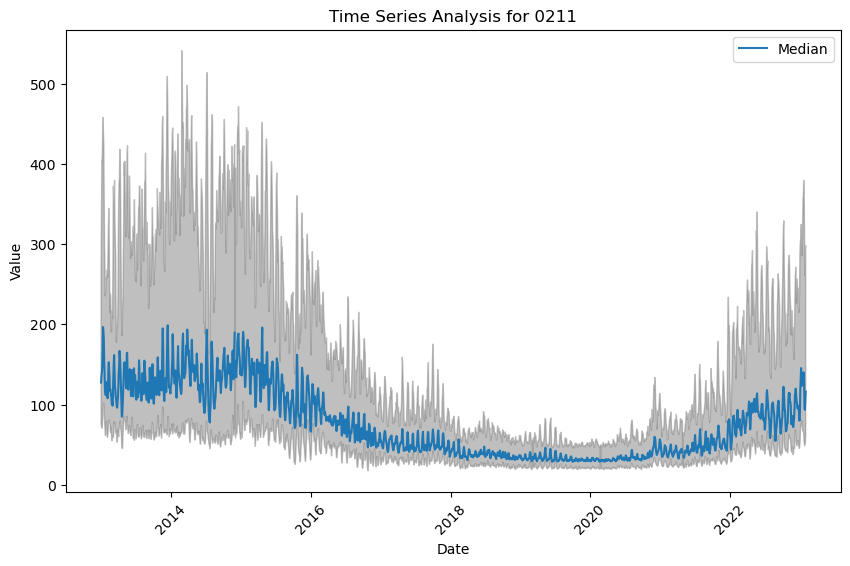

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class TimeSeries:
    def __init__(self, start, end, day_cadence=1, wavelength='0021', rsun=1, minval=0.01):
        self.start = start
        self.end = end
        self.cadence = day_cadence
        self.wavelength = wavelength
        self.rsun = rsun
        self.minval = minval
        self.images = []
        self.stats = []
        self.dates = []  

    def process_images(self):
        urls_generator = get_aia_image_urls(self.start, self.end, self.wavelength, self.cadence)
        for url in urls_generator:
            try:
                if url: 
                    img = AImage(url, self.rsun, self.minval)
                    self.images.append(img)
                    date = img.extract_date(url) 
                if date is not None:
                    self.dates.append(date)
            except Exception as e:
                print(f"Error processing image from URL {url}: {e}")
                continue
            
    def analyze_stats(self):
        for img in self.images:
            highest = img.image.max()
            lowest = img.image.min()
            median = img.compute_median()
            percentile_16 = img.compute_percentile(16)
            percentile_84 = img.compute_percentile(84)
            mean = img.compute_mean()
            if median < 20:  
                median = np.nan
                percentile_16 = np.nan
                percentile_84 = np.nan
                mean = np.nan
                highest = np.nan
                lowest = np.nan
            self.stats.append((median, percentile_16, percentile_84, mean, highest, lowest))


    def find_max_min_medium(self):
        medium_stats = [(v[1], i) for i, v in enumerate(self.stats) if not np.isnan(v[1])]
        if not medium_stats:
            return [None]*4
        max_stat = max(medium_stats)
        min_stat = min(medium_stats)
        return max_stat[0], min_stat[0], self.dates[max_stat[1]], self.dates[min_stat[1]]



    def save_to_csv(self, filename):
        df = pd.DataFrame(self.stats, columns=['Median', '16th Percentile', '84th Percentile', 'Mean', 'Max', 'Min'])
        df['Date'] = self.dates  
        df.to_csv(filename, index=False)
    
    def plot_time_series(self):
        df = pd.DataFrame(self.stats, columns=['Median', '16th Percentile', '84th Percentile', 'Mean', 'Max', 'Min'])
        df['Date'] = pd.to_datetime(self.dates)  
        plt.figure(figsize=(10, 6))
        plt.plot(df['Date'], df['Median'], label='Median')
        plt.fill_between(df['Date'], df['16th Percentile'], df['84th Percentile'], color='gray', alpha=0.5)
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Time Series Analysis for 0211')
        plt.legend()
        plt.xticks(rotation=45) 
        plt.show()

    

ts_UV_0211 = TimeSeries('2013-01-01', '2023-01-31', 2 , '0211', 1.0, 0.01)

ts_UV_0211.process_images()

ts_UV_0211.analyze_stats()

ts_UV_0211.save_to_csv('timeseries_UV_0211_daily.csv')

ts_UV_0211.plot_time_series()



For 0094:

Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2014/09/23/H0000/AIA20140923_0000_0094.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2015/12/27/H0000/AIA20151227_0000_0094.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/03/H0000/AIA20160803_0000_0094.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/05/H0000/AIA20160805_0000_0094.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/07/H0000/AIA20160807_0000_0094.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2016/08/09/H0000/AIA20160809_0000_0094.fits: HTTP Error 404: Not Found
Error processing image from URL http://jsoc.stanford.edu/data/aia/synoptic/2018/11/17/H0000/AIA20181117_0000_0094.fits: HTTP

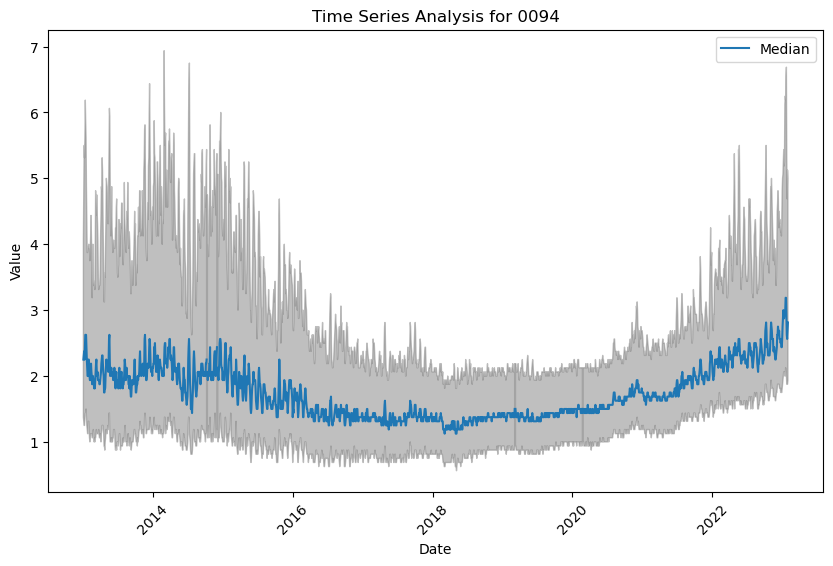

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

class TimeSeries:
    def __init__(self, start, end, day_cadence=1, wavelength='0021', rsun=1, minval=0.01):
        self.start = start
        self.end = end
        self.cadence = day_cadence
        self.wavelength = wavelength
        self.rsun = rsun
        self.minval = minval
        self.images = []
        self.stats = []
        self.dates = []  

    def process_images(self):
        urls_generator = get_aia_image_urls(self.start, self.end, self.wavelength, self.cadence)
        for url in urls_generator:
            try:
                if url: 
                    img = AImage(url, self.rsun, self.minval)
                    self.images.append(img)
                    date = img.extract_date(url) 
                if date is not None:
                    self.dates.append(date)
            except Exception as e:
                print(f"Error processing image from URL {url}: {e}")
                continue
            
    def analyze_stats(self):
        for img in self.images:
            highest = img.image.max()
            lowest = img.image.min()
            median = img.compute_median()
            percentile_16 = img.compute_percentile(16)
            percentile_84 = img.compute_percentile(84)
            mean = img.compute_mean()
            if median > 4 or median < 0.5:  
                median = np.nan
                percentile_16 = np.nan
                percentile_84 = np.nan
                mean = np.nan
                highest = np.nan
                lowest = np.nan
            self.stats.append((median, percentile_16, percentile_84, mean, highest, lowest))


    def find_max_min_medium(self):
        medium_stats = [(v[1], i) for i, v in enumerate(self.stats) if not np.isnan(v[1])]
        if not medium_stats:
            return [None]*4
        max_stat = max(medium_stats)
        min_stat = min(medium_stats)
        return max_stat[0], min_stat[0], self.dates[max_stat[1]], self.dates[min_stat[1]]


    def save_to_csv(self, filename):
        df = pd.DataFrame(self.stats, columns=['Median', '16th Percentile', '84th Percentile', 'Mean', 'Max', 'Min'])
        df['Date'] = self.dates  
        df.to_csv(filename, index=False)
    
    def plot_time_series(self):
        df = pd.DataFrame(self.stats, columns=['Median', '16th Percentile', '84th Percentile', 'Mean', 'Max', 'Min'])
        df['Date'] = pd.to_datetime(self.dates)  
        plt.figure(figsize=(10, 6))
        plt.plot(df['Date'], df['Median'], label='Median')
        plt.fill_between(df['Date'], df['16th Percentile'], df['84th Percentile'], color='gray', alpha=0.5)
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.title('Time Series Analysis for 0094')
        plt.legend()
        plt.xticks(rotation=45) 
        plt.show()

    

ts_UV_0094 = TimeSeries('2013-01-01', '2023-01-31', 2 , '0094', 1.0, 0.01)

ts_UV_0094.process_images()

ts_UV_0094.analyze_stats()

ts_UV_0094.save_to_csv('timeseries_UV_0094_daily.csv')

ts_UV_0094.plot_time_series()


2(c). Examine the time series plot and present a discussion of whether there are cycles of activity of the Sun (regular or irregular) on the timescales shorter than 11 years (the main cycle of Solar activity).

As shown in the two time series plots, we could see the long-term 11 years main cycle of sun. For shorter term less than 11 years, the variations are mostly irregular. 

However, there is also some regular variability observed, such as the monthly varaitions due to the group of Sun spots coming into view and disappearing on Sun's 27 days rotation. Hence, when the median and percentile fluctuations on the 27-day scale is very small, there are very few Sun spots. 

At the same time, the median and 84th percentile curves proves the irregularity on the time scale of several months and years. These events happen randomly.

2(d). Display and examine images in 2 filters (0094 and 1600) at the dates where you observe highest peaks and lowest dips to see what these peaks and dips correspond to visually.

Find highest peaks and lowest dips:

In [19]:
max_values_0211, min_values_0211, max_dates_0211, min_dates_0211 = ts_UV_0211.find_max_min_medium()

print(f'Max Values of 0211: {max_values_0211} at dates {max_dates_0211}')
print(f'Min Values of 0211: {min_values_0211} at dates {min_dates_0211}')



Max Values of 0211: 103.875 at dates 2015/01/13
Min Values of 0211: 17.625 at dates 2016/10/26


In [20]:
max_values_0094, min_values_0094, max_dates_0094, min_dates_0094 = ts_UV_0094.find_max_min_medium()

print(f'Max Values of 0094: {max_values_0094} at dates {max_dates_0094}')
print(f'Min Values of 0094: {min_values_0094} at dates {min_dates_0094}')


Max Values of 0094: 2.125 at dates 2023/01/19
Min Values of 0094: 0.5625 at dates 2018/05/05


Correspond to visually graphs:

In [21]:
from matplotlib import pylab as plt
from matplotlib.colors import LogNorm

def plot_image(image, log=False, title=None):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    if log: 
        ax.imshow(image, cmap='afmhot', origin='lower', norm=LogNorm())
    else: 
        ax.imshow(image, cmap='afmhot', origin='lower') 
        
    _ = ax.axis('off')
    
    if title is not None: ax.set_title(title)
        
    plt.show()

In [22]:
from astropy.io import fits

def read_aia_synoptic_image(url): 
    '''
    Read SDO image from the input URL
    
    Parameters:
        url: str, URL of the image to read
        
    Returns:
        image - 2D array of floats
        img_header - FITS header of the image
    '''
    # open FITS file from input URL
    fimg = fits.open(url) 
    image = fimg[1].data # this will produce image as a numpy array
    img_header = fimg[1].header # FITS header contains detailed info about image, save it in case we will need
    fimg.close()
    
    return image, img_header

In [23]:
def set_sun_aperture(img, img_header, rsun_factor=1, minval=0.01):
    '''
    set all pixels outside rsun_factor*r_sun, where r_sun is Sun radius in image to minval
    
    This version uses loops to iterate through all image pixels
    '''
    # radius of the Sun in arcseconds
    r_sun = img_header["IMSCL_MP"] * img_header['R_SUN']
    # number of arcseconds per pixel in x and y directions
    dx_pix2sec, dy_pix2sec = img_header['CDELT1'], img_header['CDELT2']
    
    _img = np.copy(img)
    imin = _img.min()
    nrow, ncol = np.shape(_img)
    isum, nsum = 0, 0  
    nrh = nrow // 2
    nch = ncol // 2
    for i in range(nrow): 
        for j in range(ncol):
            rij = (((i-nch)*dx_pix2sec)**2 + ((j-nrh)*dy_pix2sec)**2)**0.5
            if rij > rsun_factor * r_sun:
                _img[i][j] = minval
                
    return _img

In [24]:
def set_sun_aperture_np(img, img_header, rsun_factor=1, minval=0.01):
    '''
    set all pixels outside rsun_factor*r_sun, where r_sun is Sun radius in image to minval

    This version uses NumPy to process all image pixels without loops
    '''
    # radius of the Sun in arcseconds
    r_sun = img_header["IMSCL_MP"] * img_header['R_SUN']
    # number of arcseconds per pixel in x and y directions
    dx_pix2sec, dy_pix2sec = img_header['CDELT1'], img_header['CDELT2']
    
    _img = np.copy(img)
    imin = _img.min()
    nrow, ncol = np.shape(_img)
    isum, nsum = 0, 0  
    nrh = nrow // 2
    nch = ncol // 2
    Y, X = np.ogrid[:nrow, :ncol]
    rcenter = np.sqrt(((X - nch)*dx_pix2sec)**2 + ((Y - nrh)*dy_pix2sec)**2)
    rcut = rsun_factor * r_sun
    _img[rcenter > rcut] = minval        
    return _img

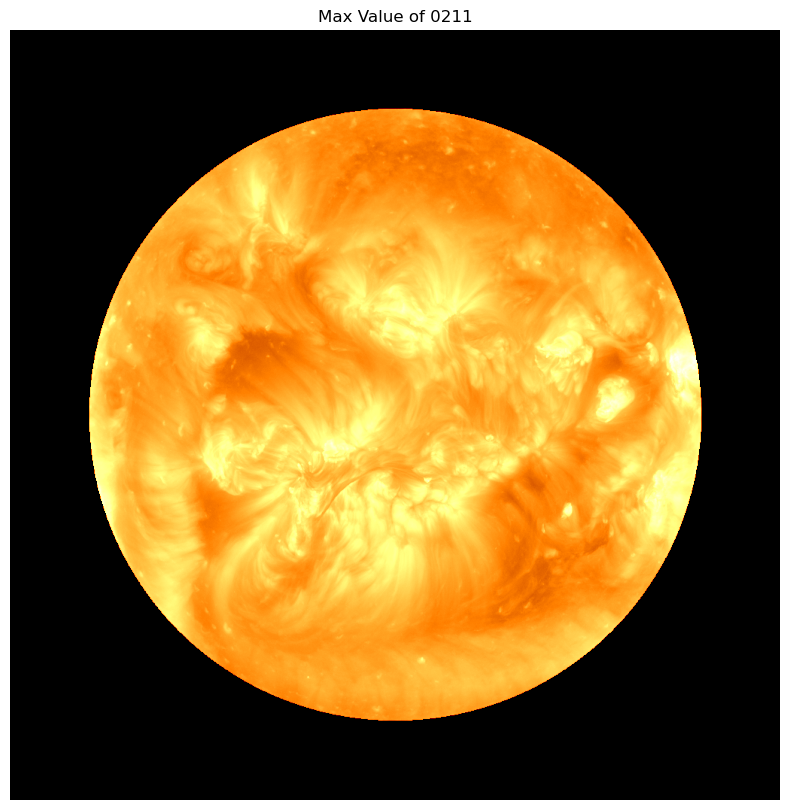

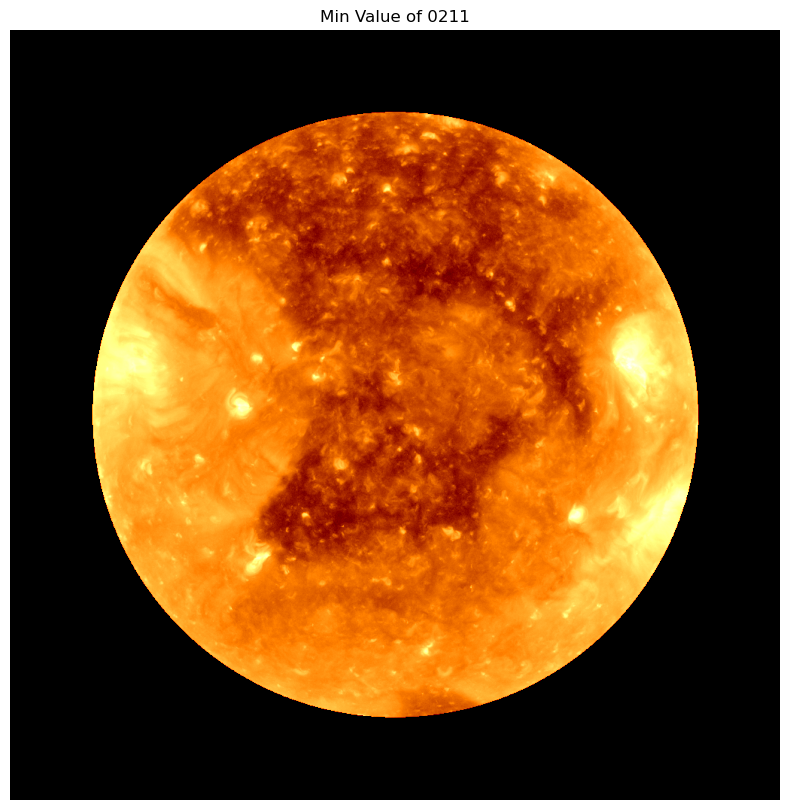

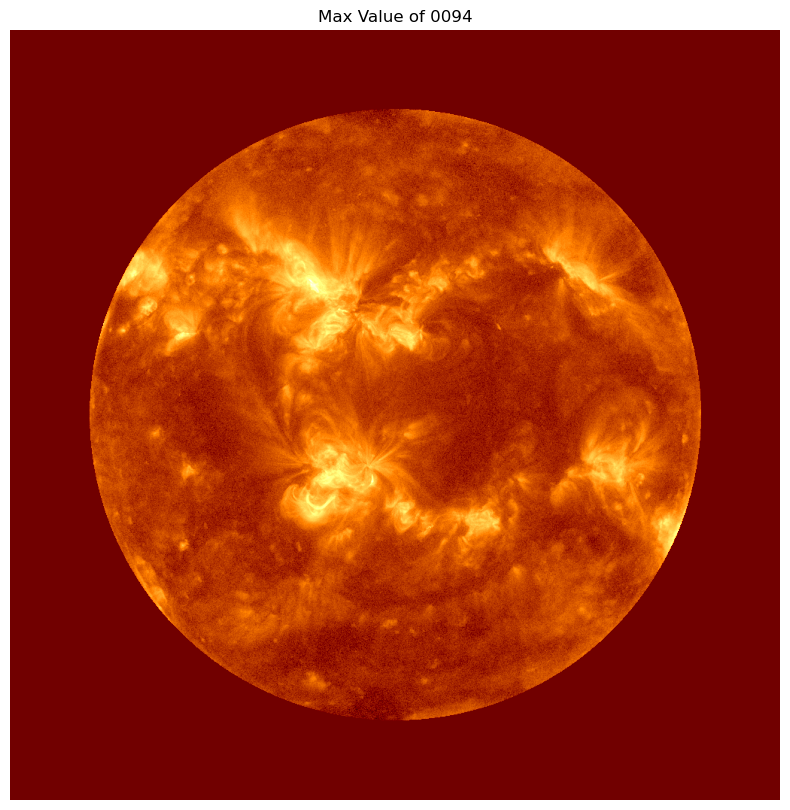

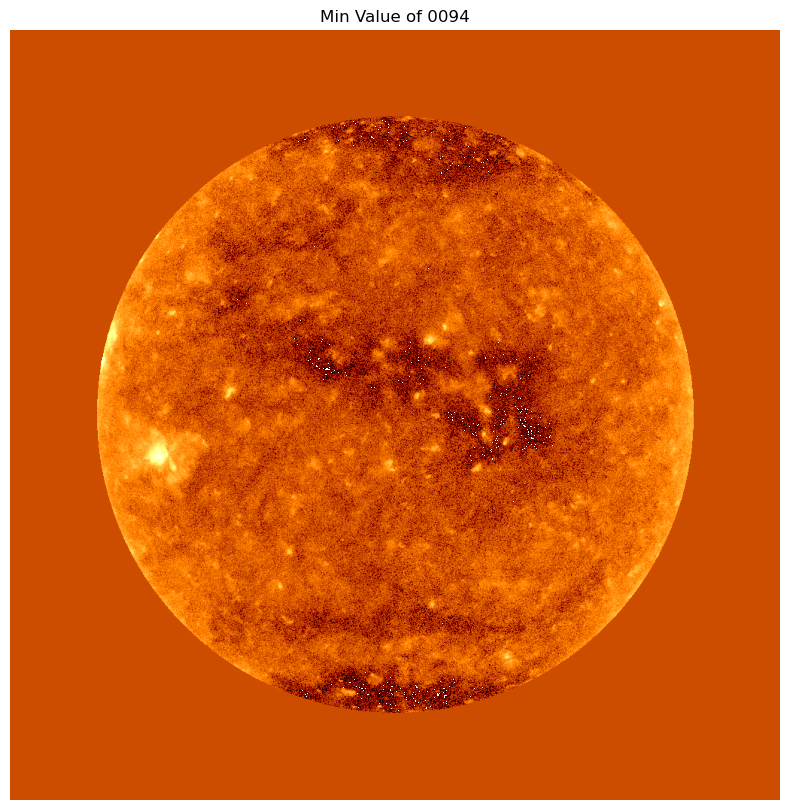

In [25]:

dates_0211 = ['2015/01/13','2016/10/26']
filt_0211 = '0211'
urls_0211 = []
for date in dates_0211:
    year, month, day = date.split('/')
    formatted_year = year
    formatted_month = month.zfill(2)
    formatted_day = day.zfill(2)
    url = f"http://jsoc.stanford.edu/data/aia/synoptic/{formatted_year}/{formatted_month}/{formatted_day}/H0000/AIA{formatted_year}{formatted_month}{formatted_day}_0000_{filt_0211}.fits"
    urls_0211.append(url)



dates_0094 = ['2023/01/19', '2018/05/05']
filt_0094 = '0094'
urls_0094 = []
for date in dates_0094:
    year, month, day = date.split('/')
    formatted_year = year
    formatted_month = month.zfill(2)
    formatted_day = day.zfill(2)
    url = f"http://jsoc.stanford.edu/data/aia/synoptic/{formatted_year}/{formatted_month}/{formatted_day}/H0000/AIA{formatted_year}{formatted_month}{formatted_day}_0000_{filt_0094}.fits"
    urls_0094.append(url)

urls = [urls_0211[0], urls_0211[1], urls_0094[0], urls_0094[1]]


titles = ['Max Value of 0211', 'Min Value of 0211', 'Max Value of 0094', 'Min Value of 0094']


for url, title in zip(urls, titles):
    img, img_header = read_aia_synoptic_image(url)
    img_processed = set_sun_aperture_np(img, img_header, minval=1, rsun_factor=1.0)
    plot_image(img_processed, log=True, title=title)
    

Histogram on distribution of pixel values:

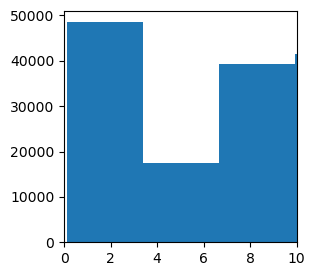

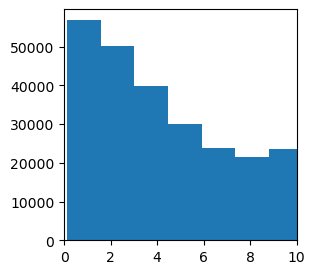

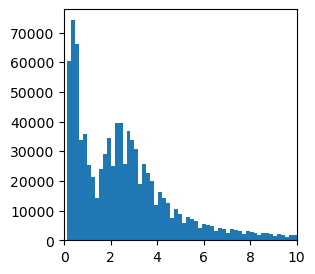

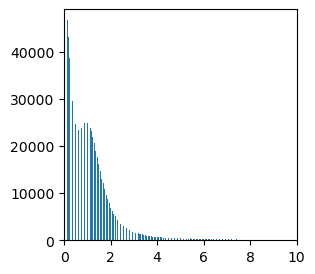

In [26]:
for url, title in zip(urls, titles):
    img, img_header = read_aia_synoptic_image(url)
    img_processed = set_sun_aperture_np(img, img_header, minval=1, rsun_factor=1.0)

    sunpix = img[img>0.1]
    spmed = np.median(sunpix)
    
    plt.figure(figsize=(3,3))
    plt.xlim(0.,10)
    plt.hist(sunpix.flatten(), bins=2000)
    plt.show()

Forming a "false color" image: 

I applied a third data of different wavelength (0193), and showed the combined image of the three different wavelength.

In [28]:
dates_0131 = ['2022/01/01']
filt_0131 = '0131'
urls_0131 = []
for date in dates_0131:
    year, month, day = date.split('/')
    formatted_year = year
    formatted_month = month.zfill(2)
    formatted_day = day.zfill(2)
    url = f"http://jsoc.stanford.edu/data/aia/synoptic/{formatted_year}/{formatted_month}/{formatted_day}/H0000/AIA{formatted_year}{formatted_month}{formatted_day}_0000_{filt_0131}.fits"
    urls_0131.append(url)

shape of the combined image array: (1024, 1024, 3)


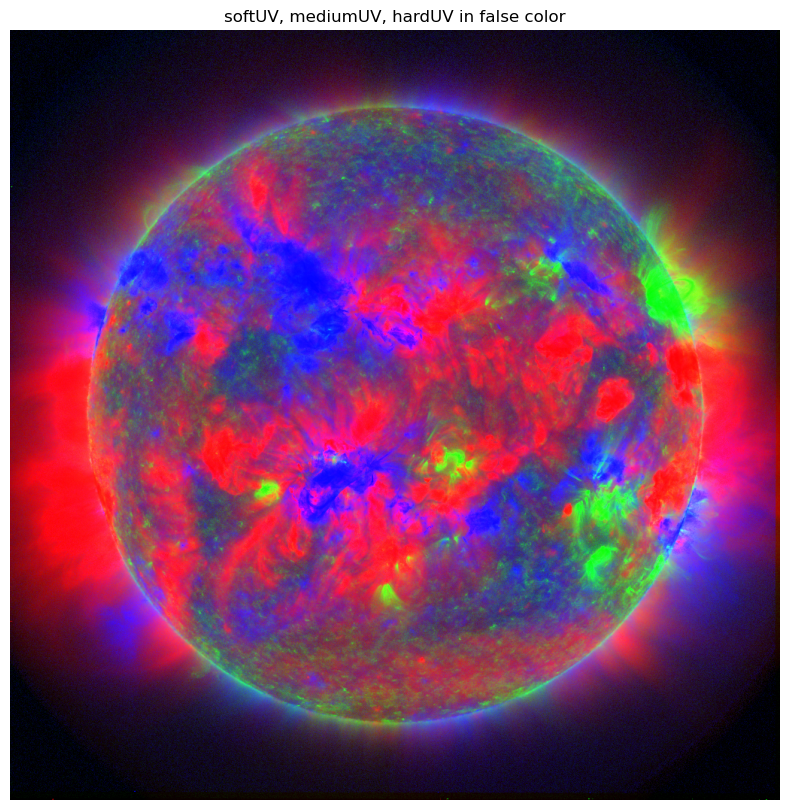

In [30]:
url_0211 = urls_0211[0]
img4, img_header4 = read_aia_synoptic_image(url_0211)

url_0131 = urls_0131[0]
img3, img_header3 = read_aia_synoptic_image(url_0131)

url_0094 = urls_0094[0]
img2, img_header2 = read_aia_synoptic_image(url_0094)

from astropy.visualization import make_lupton_rgb

imgc = make_lupton_rgb(img4, 12*img3, 50*img2, Q=7, stretch=150)

print(f'shape of the combined image array: {imgc.shape}')

plot_image(imgc, log=True, title='softUV, mediumUV, hardUV in false color')


Extra-credit:


Compute correlation coefficients for time series in the two filters (see below for the definition) to assess how correlated the activity at these wavelengths. You should write your own code to compute correlation coefficient using equations below, although you can use functions such as sum or np.sum.

I found out that my dataframes are in different shapes (different number of rows)

In [31]:
df_UV_0094 = pd.read_csv('timeseries_UV_0094_daily.csv')
print(len(df_UV_0094))
df_UV_0211 = pd.read_csv('timeseries_UV_0211_daily.csv')
print(len(df_UV_0211))

1830
1826


So I convert them into same dimensions before executing operations

In [32]:

df_UV_0094 = pd.read_csv('timeseries_UV_0094_daily.csv')
df_UV_0211 = pd.read_csv('timeseries_UV_0211_daily.csv')


if len(df_UV_0094) > len(df_UV_0211):
    df_UV_0094 = df_UV_0094.iloc[:len(df_UV_0211)]
elif len(df_UV_0211) > len(df_UV_0094):
    df_UV_0211 = df_UV_0211.iloc[:len(df_UV_0094)]


def compute_correlation_coefficient(series1, series2):

    assert len(series1) == len(series2)
    mean1 = np.mean(series1)
    mean2 = np.mean(series2)
    deviations1 = series1 - mean1
    deviations2 = series2 - mean2
    correlation_coefficient = np.sum(deviations1 * deviations2) / np.sqrt(np.sum(deviations1**2) * np.sum(deviations2**2))
    return correlation_coefficient


correlation_coefficient = compute_correlation_coefficient(df_UV_0094['Median'], df_UV_0211['Median'])

print(f"The correlation coefficient between the two time series is {correlation_coefficient}")

The correlation coefficient between the two time series is 0.6907714449748507


The correlation value is 0.69, which is between moderately and highly correlated